# How Moral Emotions Spread Political Messages on Twitter (with Ease) 

Hi there! This is Yara's and Hui Wen's notebook for the research on moral emotional spread of tweets. It has four parts:

1. Filtering and Cleaning Raw Data 
2. Matching and Counting Retweets
3. Counting Moral-Emotional Words and Gunning Fog Index
4. Negative Binomial Regression 

If you have any questions or concerns, please reach out to yara@nyu.edu or hwg222@nyu.edu. 

Enjoy! 


In [1]:
!pip install syllables

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')

from tqdm import tqdm
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 
import syllables
import statsmodels.formula.api as smf 
import statsmodels.api as sm


import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


## Part 1: Filtering and Cleaning Raw Data


In [4]:
# df = pd.read_csv("G_raw.csv",encoding='UTF-8')
df = pd.read_csv('/drive/My Drive/NLP Project/Existing Data/Raw Data/G_raw.csv')

In [5]:
gun_keywords = ["guncontrol","gunviolence","endgunviolence",
                "second amendment","2nd amendment", "2A", "gunlaws",
                "gunsense","gunsafety","gun culture","gun murders",
                "gun threat","gun offenses","gun crisis","gun reform",
                "gun owner","gun owners","gun ownership","gun crime","gun ban","gun smuggling",
                "gun confiscation","gun rights","gun deaths","gun violence","gun safety",
                "gun laws","gun control"]

In [6]:
def preproc_fileter(dataor, keywords):
    #Effect coding and renaming columns
    dataor["url"] = np.where(dataor["contains.url"] == True, 1, -1)
    dataor["media"] = np.where(dataor["contains.media"] == True, 1, -1)
    dataor["verified"] = np.where(dataor["user.verified"] == True, 1, -1)
    dataor = dataor.drop(["contains.url","contains.media","user.verified"], 1)
    dataor = dataor.rename(columns={"timestamp":"time", "id_str": "twid", 
                                    "retweeted_status.id_str":"rtwid", "user.id_str": "userid",
                                    "user.screen_name":"username", "user.location": "location",
                                    "user.description": "description", "user.followers_count": "followers"})

    #Minor text Preprocessing
    dataor["text"] = [str(re.sub(r"http\S+", "", text)) for text in dataor["text"]]
    dataor["text"] = [str(re.sub("&amp;#8216;|&amp;#8211;|&amp;#8217;|&amp;#039;|&amp;#8230;", "", text)) for text in dataor["text"]]
    dataor["text"] = [str(re.sub("[\u201C\u201D\u201E\u201F\u2033\u2036\u2018\u2019\u201A\u201B\u2032\u2035]", "'", text)) for text in dataor["text"]]
    dataor["text"] = [str(re.sub("&amp;", "&", text)) for text in dataor["text"]]
    dataor["text"] = [str(re.sub("<f0><9f><94><ab>", "", text)) for text in dataor["text"]]
    dataor["text"] = [str(re.sub("#gunsens<e", "#gunsense", text)) for text in dataor["text"]]
    text = dataor["text"].copy() 
    text = [str(re.sub('[!.?$%\(\)‘’*+,-/:;<=>\[\\]^_`{|}~]', "", doc.lower())) for doc in text]
    
    dataor["prepr_text"] = text
    
    #Filtering by keywords
    contains = dataor["prepr_text"].str.contains("("+"|".join(keywords)+")", case=False, regex=True)
    data = dataor.loc[contains]
   
    del dataor
    
    #Remove duplicate ids
    data = data.drop_duplicates(subset=["twid"])
    
    return data      

In [7]:
clean = preproc_fileter(df, gun_keywords)

In [8]:
clean.head()

,twid,time,rtwid,userid,username,location,description,text,followers,ideology,url,media,verified,prepr_text
1,661664563377676288,2015-11-03 22:01:39,NaN,38122727,ROCKWITHBECK,"Atlanta, Georgia",War Veteran who loves his country. Never forge...,BOYCOTT NOV 4 @ABC @CMAwards &gt; THREAT TO AL...,20664,0.895322,1,-1,-1,boycott nov 4 @abc @cmawards &gt threat to all...
2,661664567940874240,2015-11-03 22:01:40,6.616639e+17,379954624,BUSHADEMOCRAT,OREGON,Browns Fan / Reds Fan / Never voting for REPUB...,RT @AddInfoOrg: 'Responsible Gun Owner' Gives ...,1045,-0.462759,1,-1,-1,rt @addinfoorg 'responsible gun owner' gives 5...
4,661664601616969728,2015-11-03 22:01:48,6.615296e+17,15989428,LarryLigouri,San Francisco | Santa Rosa,Rabble-rouser. Proud #union organizer and memb...,RT @HillaryClinton: Watch our new ad—why Hilla...,326,-0.575658,1,-1,-1,rt @hillaryclinton watch our new ad—why hillar...
6,661664632856313856,2015-11-03 22:01:56,6.616549e+17,2252890903,alizinaty,tripoli international airport,<U+0627><U+0644><U+0644><U+0647><U+0645> <U+06...,RT @HillaryforIA: Hillary on gun violence prev...,3579,-0.932990,-1,1,-1,rt @hillaryforia hillary on gun violence preve...
11,661664661981515776,2015-11-03 22:02:03,NaN,216705818,MCarsonMitchell,Florida State University,"Intl affairs fanatic, environmentalist, and me...","Got some juicy stories - DCF neglect, GA gun s...",181,0.862439,-1,-1,-1,got some juicy stories dcf neglect ga gun smu...


## Part 2: Matching and Counting Retweets

In [9]:
def prepr_retweets(data):
    #Split into retweets and originals-insample
    RT = data.loc[data["rtwid"].isnull() == False]
    notRT = data.loc[data["rtwid"].isnull() == True]
    
    RT["rtwid"] = RT["rtwid"].copy().astype(int)
    
    text = RT["prepr_text"].copy()
    text = [doc[3:] for doc in text]    # taking the text after 'rt'
    RT["username"] = [doc.split()[0][1:] for doc in text]   # obtaining the username of the original author 
    RT["prepr_text"] = [" ".join(doc.split()[1:]) for doc in text]
    notRT["username"] = [name.lower() for name in notRT["username"]]
    
    return RT, notRT  

In [10]:
retweets, originals = prepr_retweets(clean)

In [11]:
def split_match(RT, notRT):
    insam = set(RT["rtwid"]).intersection(set(notRT["twid"]))
    notrt = set(notRT["twid"]).difference(insam)
    
    #Count retweets per original (in or outsample)
    rtcount = RT.groupby(["rtwid"]).agg({"rtwid": "count"})
    rtcount.columns = ["count"]
    
    #Marking original tweets for retweets that are insample
    rtcount["insample"] = np.zeros(len(rtcount), dtype=bool)
    for i in list(insam):
        rtcount.loc[i,"insample"] = True

    rtcount["rtwid"] = rtcount.index 
    rtcountout = pd.DataFrame({'count': 0, 'rtwid': list(notrt), "insample": True})
    
    rt = rtcount.append(rtcountout, ignore_index=True)
    
    #Appending and combining a bunch of stuff correctly
    rtin = rt.loc[rt["insample"] == True]
    rtin = rtin.set_index("rtwid")
    notRT = notRT.set_index("twid")
    new = notRT.join(rtin)
    
    rtout = rt.loc[rt["insample"] == False]
    rtout = rtout.set_index("rtwid")
    RTdrop = RT.drop_duplicates(subset=["rtwid"])
    RTdrop = RTdrop.set_index("rtwid")
    RTdrop = RTdrop.loc[rtout.index]
    RTdrop = RTdrop.join(rtout)
    
    final = new.append(RTdrop)
    final = final.drop(["twid","rtwid"],axis=1)

    return final

In [12]:
def accounting_for_dupes(data):
    data["both"] = data["username"]+" "+data["prepr_text"]
    group = data.groupby(["both"]).agg({"count":"sum"})
    drop = data.drop_duplicates(subset="both")
    dropindex = drop.set_index("both")
    dropdone = dropindex.drop("count",1)
    final = dropdone.join(group)
    
    return final

In [13]:
fullset = split_match(retweets, originals)

In [14]:
ready = accounting_for_dupes(fullset)

In [15]:
codef moreprep(data):
    insample = data.loc[data["insample"] == True]
    outsample = data.loc[data["insample"] == False]
    
    N = len(outsample)
    outsample["followers"] = np.mean(insample["followers"].copy())*np.ones(N)
    outsample["ideology"] = np.mean(insample["ideology"].copy())*np.ones(N)
    
    df = insample.append(outsample)
    df = df.drop(["time","userid", "username","location", "description"],1)
    
    return df

In [16]:
prepped = moreprep(ready)

In [17]:
prepped.reset_index(inplace=True)
prepped.head()

,both,text,followers,ideology,url,media,verified,prepr_text,insample,count
0,rockwithbeck boycott nov 4 @abc @cmawards &gt ...,BOYCOTT NOV 4 @ABC @CMAwards &gt; THREAT TO AL...,20664.0,0.895322,1,-1,-1,boycott nov 4 @abc @cmawards &gt threat to all...,True,2
1,mcarsonmitchell got some juicy stories dcf ne...,"Got some juicy stories - DCF neglect, GA gun s...",181.0,0.862439,-1,-1,-1,got some juicy stories dcf neglect ga gun smu...,True,0
2,alizinaty @hillaryforia @hillaryclinton hillar...,@HillaryforIA @HillaryClinton Hillary on gun v...,3579.0,-0.932990,-1,1,-1,@hillaryforia @hillaryclinton hillary on gun v...,True,0
3,nealfox this should end the argument about wha...,This should end the argument about what the 2n...,793.0,1.394052,1,-1,-1,this should end the argument about what the 2n...,True,0
4,kimmie99 @publiushuldah @randomhero30 that's t...,@PubliusHuldah @RandomHero30 that's tattooed o...,6203.0,2.027604,-1,-1,-1,@publiushuldah @randomhero30 that's tattooed o...,True,0


## Part 3: Counting Moral-Emotional Words and Gunning Fog Index

In [18]:
#Tokenize and stem the tweets
def tokenize(corpus):
    corpus = [str(re.sub(r"@\S+", "", text.lower())) for text in corpus]
    corpus = [str(re.sub(r"#", "", text)) for text in corpus]

    ps = PorterStemmer()

    for i in tqdm(range(len(corpus))):
        corpus[i] = [ps.stem(j) for j in word_tokenize(corpus[i])if (j.isalnum() and not j.isnumeric())]

    return corpus

In [19]:
prepped['tokenized'] = tokenize(prepped['prepr_text'])

100%|██████████| 56858/56858 [00:24<00:00, 2341.64it/s]


In [20]:
#Moral emotional word dictionaries obtained from Brady et al.
#Includes all moral emotional words, and also separated into positive/negative groups

me_words = pd.read_csv('/drive/My Drive/NLP Project/Existing Data/Dictionaries/shared.txt', header=None)
pos_words = pd.read_csv('/drive/My Drive/NLP Project/Existing Data/Dictionaries/shared_pos.txt', header=None)
neg_words = pd.read_csv('/drive/My Drive/NLP Project/Existing Data/Dictionaries/shared_neg.txt', header=None)

#me_words = pd.read_csv('shared.txt', header=None)
#pos_words = pd.read_csv('shared_pos.txt', header=None)
#neg_words = pd.read_csv('shared_neg.txt', header=None)

In [21]:
me_words = np.array(me_words).ravel()
pos_words = np.array(pos_words).ravel()
neg_words = np.array(neg_words).ravel()

ps = PorterStemmer()
        
me_words = [ps.stem(me_words[i].strip('*')) for i in range(len(me_words))]    
pos_words = [ps.stem(pos_words[i].strip('*')) for i in range(len(pos_words))] 
neg_words = [ps.stem(neg_words[i].strip('*')) for i in range(len(neg_words))] 

In [22]:
def count_words(word_dict, tokenized_review):
    word_count = 0
    for token in tokenized_review:
        if token in word_dict:
            word_count += 1

    return word_count

In [23]:
prepped['total_words'] = [count_words(me_words, text) for text in prepped['tokenized']]
prepped['pos_words'] = [count_words(pos_words, text) for text in prepped['tokenized']]
prepped['neg_words'] = [count_words(neg_words, text) for text in prepped['tokenized']]

In [24]:
prepped.head()

,both,text,followers,ideology,url,media,verified,prepr_text,insample,count,tokenized,total_words,pos_words,neg_words
0,rockwithbeck boycott nov 4 @abc @cmawards &gt ...,BOYCOTT NOV 4 @ABC @CMAwards &gt; THREAT TO AL...,20664.0,0.895322,1,-1,-1,boycott nov 4 @abc @cmawards &gt threat to all...,True,2,"[boycott, nov, gt, threat, to, all, gun, owner...",0,0,0
1,mcarsonmitchell got some juicy stories dcf ne...,"Got some juicy stories - DCF neglect, GA gun s...",181.0,0.862439,-1,-1,-1,got some juicy stories dcf neglect ga gun smu...,True,0,"[got, some, juici, stori, dcf, neglect, ga, gu...",0,0,0
2,alizinaty @hillaryforia @hillaryclinton hillar...,@HillaryforIA @HillaryClinton Hillary on gun v...,3579.0,-0.932990,-1,1,-1,@hillaryforia @hillaryclinton hillary on gun v...,True,0,"[hillari, on, gun, violenc, prevent, i, will, ...",1,0,1
3,nealfox this should end the argument about wha...,This should end the argument about what the 2n...,793.0,1.394052,1,-1,-1,this should end the argument about what the 2n...,True,0,"[thi, should, end, the, argument, about, what,...",0,0,0
4,kimmie99 @publiushuldah @randomhero30 that's t...,@PubliusHuldah @RandomHero30 that's tattooed o...,6203.0,2.027604,-1,-1,-1,@publiushuldah @randomhero30 that's tattooed o...,True,0,"[that, tattoo, onto, my, leg, 2a, on, other, s...",0,0,0


In [25]:
def fog(df):
    new = []
    for i in df.index:
        text = df["text"][i].lower()
        sent = re.split("[.!?…]", text)
        text = str(re.sub(r"@\S+", "", text))
        text = str(re.sub(r"#\S+", "", text))
        text = str(re.sub('[!.?$%\(\)‘’*+,-/:;<=>\[\\]^_`{|}~]', "", text))
        tokens = text.split()
        hard_words = [syllables.estimate(token) for token in tokens if syllables.estimate(token) > 2]
        if len(tokens)*len(sent) != 0:
            avgwordpersent = len(tokens)/len(sent)
            percent = 100*len(hard_words)/len(tokens)
            new.append(0.4*(avgwordpersent + percent))
        else: 
            new.append(0)
    return new

In [26]:
prepped["fog"] = fog(prepped)

In [27]:
prepped.head()

,both,text,followers,ideology,url,media,verified,prepr_text,insample,count,tokenized,total_words,pos_words,neg_words,fog
0,rockwithbeck boycott nov 4 @abc @cmawards &gt ...,BOYCOTT NOV 4 @ABC @CMAwards &gt; THREAT TO AL...,20664.0,0.895322,1,-1,-1,boycott nov 4 @abc @cmawards &gt threat to all...,True,2,"[boycott, nov, gt, threat, to, all, gun, owner...",0,0,0,5.752941
1,mcarsonmitchell got some juicy stories dcf ne...,"Got some juicy stories - DCF neglect, GA gun s...",181.0,0.862439,-1,-1,-1,got some juicy stories dcf neglect ga gun smu...,True,0,"[got, some, juici, stori, dcf, neglect, ga, gu...",0,0,0,6.743860
2,alizinaty @hillaryforia @hillaryclinton hillar...,@HillaryforIA @HillaryClinton Hillary on gun v...,3579.0,-0.932990,-1,1,-1,@hillaryforia @hillaryclinton hillary on gun v...,True,0,"[hillari, on, gun, violenc, prevent, i, will, ...",1,0,1,15.733333
3,nealfox this should end the argument about wha...,This should end the argument about what the 2n...,793.0,1.394052,1,-1,-1,this should end the argument about what the 2n...,True,0,"[thi, should, end, the, argument, about, what,...",0,0,0,9.472727
4,kimmie99 @publiushuldah @randomhero30 that's t...,@PubliusHuldah @RandomHero30 that's tattooed o...,6203.0,2.027604,-1,-1,-1,@publiushuldah @randomhero30 that's tattooed o...,True,0,"[that, tattoo, onto, my, leg, 2a, on, other, s...",0,0,0,8.036364


Some scatter plots for vizualization before fitting the NB regression:

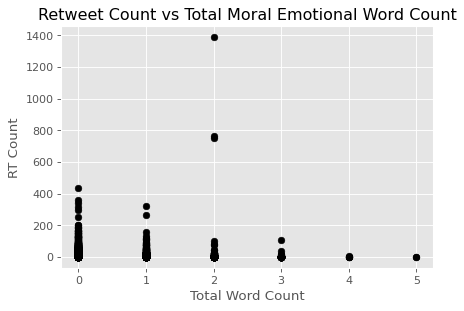

In [28]:
plt.figure(dpi=80)
plt.scatter(prepped['total_words'], prepped['count'], color='black')
plt.xlabel('Total Word Count')
plt.ylabel('RT Count')
plt.title('Retweet Count vs Total Moral Emotional Word Count')
plt.show()

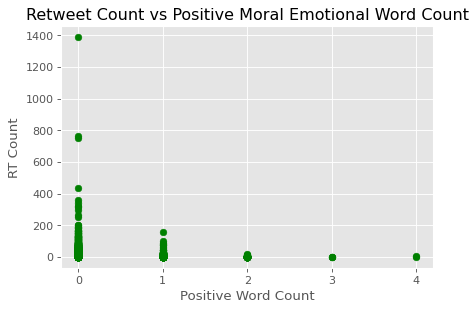

In [29]:
plt.figure(dpi=80)
plt.scatter(prepped['pos_words'], prepped['count'], color='green')
plt.xticks([0, 1, 2, 3, 4])
plt.xlabel('Positive Word Count')
plt.ylabel('RT Count')
plt.title('Retweet Count vs Positive Moral Emotional Word Count')
plt.show()

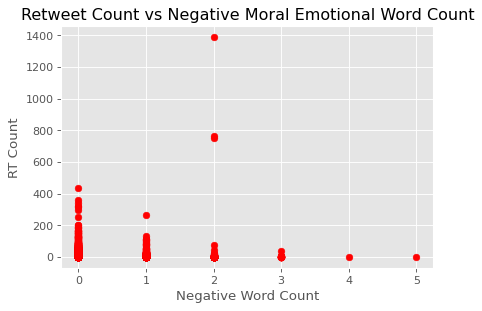

In [30]:
plt.figure(dpi=80)
plt.scatter(prepped['neg_words'], prepped['count'], color='red')
plt.xlabel('Negative Word Count')
plt.ylabel('RT Count')
plt.title('Retweet Count vs Negative Moral Emotional Word Count')
plt.show()

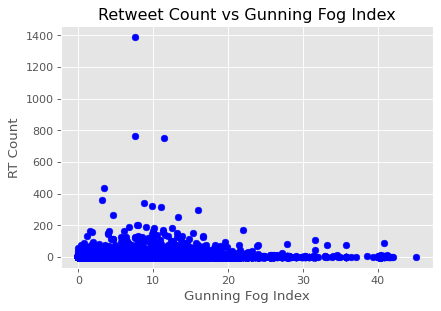

In [31]:
plt.figure(dpi=80)
plt.scatter(prepped['fog'], prepped['count'], color='blue')
plt.xlabel('Gunning Fog Index')
plt.ylabel('RT Count')
plt.title('Retweet Count vs Gunning Fog Index')
plt.show()

## Part 4: Negative Binomial Regression

In [32]:
prepped.columns

Index(['both', 'text', 'followers', 'ideology', 'url', 'media', 'verified',
       'prepr_text', 'insample', 'count', 'tokenized', 'total_words',
       'pos_words', 'neg_words', 'fog'],
      dtype='object')

In [33]:
total_words = "count ~ total_words"
pos_words = "count ~ pos_words"
neg_words = "count ~ neg_words"

fog = "count ~ fog"

everything = "count ~ followers + url + media + total_words + fog"

In [34]:
def fit_nb(df, expression):
    model = smf.glm(formula = expression, data=df, family=sm.families.NegativeBinomial()).fit()
    return model

In [35]:
total_words_model = fit_nb(prepped, total_words)
total_words_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  count   No. Observations:                56858
Model:                            GLM   Df Residuals:                    56856
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -95408.
Date:                Thu, 18 Mar 2021   Deviance:                   1.1570e+05
Time:                        21:38:29   Pearson chi2:                 1.21e+06
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.3517      0.006     60.137      0.000       0.340       0.363
total_words     0.2889      0.012     23.763      0.000       0.265       0.313
===============================================================================
"""

In [36]:
pos_words_model = fit_nb(prepped, pos_words)
pos_words_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  count   No. Observations:                56858
Model:                            GLM   Df Residuals:                    56856
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -95732.
Date:                Thu, 18 Mar 2021   Deviance:                   1.1635e+05
Time:                        21:38:29   Pearson chi2:                 1.66e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4086      0.006     73.980      0.000       0.398       0.419
pos_words     -0.0371      0.025     -1.458      0.145      -0.087       0.013
==============================================================================
"""

In [37]:
neg_words_model = fit_nb(prepped, neg_words)
neg_words_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  count   No. Observations:                56858
Model:                            GLM   Df Residuals:                    56856
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -95248.
Date:                Thu, 18 Mar 2021   Deviance:                   1.1538e+05
Time:                        21:38:29   Pearson chi2:                 1.08e+06
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3550      0.006     62.500      0.000       0.344       0.366
neg_words      0.4410      0.016     27.333      0.000       0.409       0.473
==============================================================================
"""

In [38]:
#Calculating the IRR (incidence rate ratio)
total_IRR = math.exp(total_words_model.params[1])
pos_IRR = math.exp(pos_words_model.params[1])
neg_IRR = math.exp(neg_words_model.params[1])

print("IRR for Total Moral-Emotional Word Count: {:.4f}".format(total_IRR))
print("IRR for Positive Moral-Emotional Word Count: {:.4f}".format(pos_IRR))
print("IRR for Negative Moral-Emotional Word Count: {:.4f}".format(neg_IRR))

IRR for Total Moral-Emotional Word Count: 1.3349
IRR for Positive Moral-Emotional Word Count: 0.9636
IRR for Negative Moral-Emotional Word Count: 1.5543


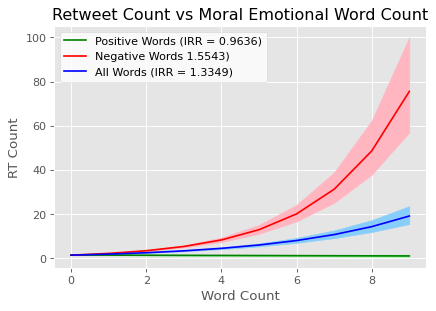

In [39]:
total_preds = total_words_model.get_prediction(pd.DataFrame(np.arange(0, 10), columns=['total_words']))
total_frame = total_preds.summary_frame(alpha=0.05)

pos_preds = pos_words_model.get_prediction(pd.DataFrame(np.arange(0, 10), columns=['pos_words']))
pos_frame = pos_preds.summary_frame(alpha=0.05)

neg_preds = neg_words_model.get_prediction(pd.DataFrame(np.arange(0, 10), columns=['neg_words']))
neg_frame = neg_preds.summary_frame(alpha=0.05)

plt.figure(dpi=80)
plt.plot(np.arange(0, 10), pos_frame['mean'], color='green')
plt.plot(np.arange(0, 10), neg_frame['mean'], color='red')
plt.plot(np.arange(0, 10), total_frame['mean'], color='blue')

plt.fill_between(np.arange(0, 10), pos_frame['mean_ci_lower'], pos_frame['mean_ci_upper'], color='palegreen')
plt.fill_between(np.arange(0, 10), neg_frame['mean_ci_lower'], neg_frame['mean_ci_upper'], color='lightpink')
plt.fill_between(np.arange(0, 10), total_frame['mean_ci_lower'], total_frame['mean_ci_upper'], color='lightskyblue')

plt.xlabel('Word Count')
plt.ylabel('RT Count')
plt.title('Retweet Count vs Moral Emotional Word Count')
plt.legend(['Positive Words (IRR = {:.4f})'.format(pos_IRR), 'Negative Words {:.4f})'.format(neg_IRR), 
            'All Words (IRR = {:.4f})'.format(total_IRR)], loc='upper left', facecolor='white')
plt.show()

In [40]:
fog_model = fit_nb(prepped, fog)
fog_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  count   No. Observations:                56858
Model:                            GLM   Df Residuals:                    56856
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -95680.
Date:                Thu, 18 Mar 2021   Deviance:                   1.1624e+05
Time:                        21:38:30   Pearson chi2:                 1.65e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5003      0.011     46.990      0.000       0.479       0.521
fog           -0.0100      0.001    -10.209      0.000      -0.012      -0.008
==============================================================================
"""

In [41]:
fog_IRR = math.exp(fog_model.params[1])

print("IRR for Gunning Fog Index: {:.4f}".format(fog_IRR))

IRR for Gunning Fog Index: 0.9901


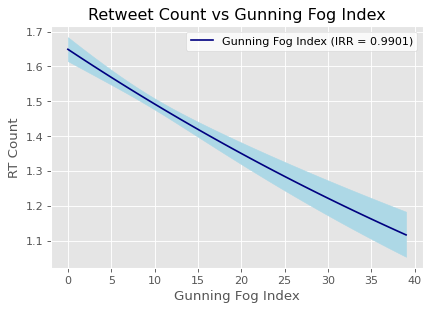

In [42]:
fog_preds = fog_model.get_prediction(pd.DataFrame(np.arange(0, 40), columns=['fog']))
fog_frame = fog_preds.summary_frame(alpha=0.05)

plt.figure(dpi=80)
plt.plot(np.arange(0, 40), fog_frame['mean'], color='navy')

plt.fill_between(np.arange(0, 40), fog_frame['mean_ci_lower'], fog_frame['mean_ci_upper'], color='lightblue')

plt.xlabel('Gunning Fog Index')
plt.ylabel('RT Count')
plt.title('Retweet Count vs Gunning Fog Index')
plt.legend(['Gunning Fog Index (IRR = {:.4f})'.format(fog_IRR)], facecolor='white')
plt.show()